# ASSIGNMENT 3: Recurrent Neural Network

*Text and sequence*

* Processing words as a sequence: The sequence model approach

In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  8700k      0  0:00:09  0:00:09 --:--:-- 16.6M


In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [3]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [4]:
from keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from google.colab import files
import re, os
from keras.datasets import imdb
from keras import preprocessing
from keras.utils import pad_sequences

## 1.Cut off reviews after 150 words

In [6]:
# Number of words to consider as features
max_features = 10000
# Cut texts after 150 words 
maxlen = 150
# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
#preprocessing.sequence.pad_sequences
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 [==============================] - 2s 0us/step


Training a initial basic sequence model 

In [7]:
model = Sequential()

# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs

model.add(Embedding(10000, 8, input_length=maxlen))

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))

#compiling the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history_1 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 36s 51ms/step - loss: 0.6120 - acc: 0.6857 - val_loss: 0.4456 - val_acc: 0.8210
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3436 - acc: 0.8620 - val_loss: 0.3264 - val_acc: 0.8644
Epoch 3/10
625/625 [=============================

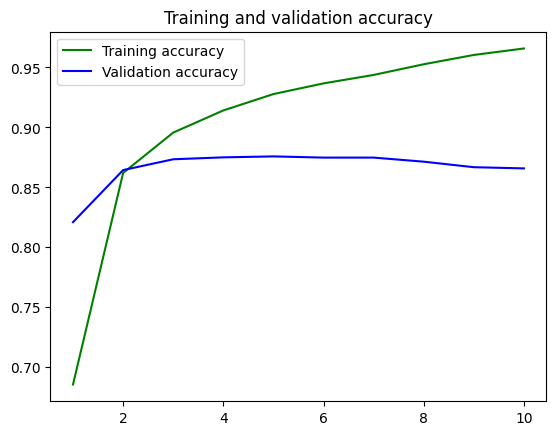

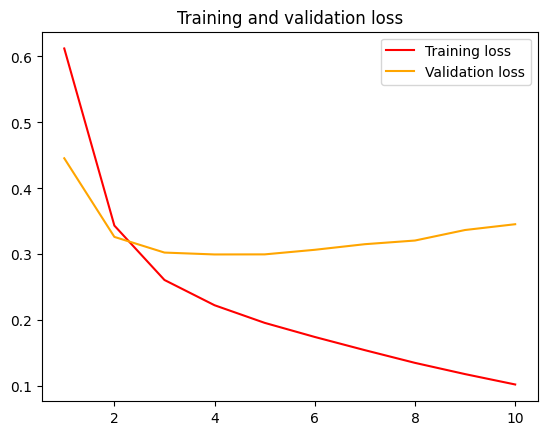

In [8]:
import matplotlib.pyplot as plt

accuracy = history_1.history['acc']
val_accuracy = history_1.history['val_acc']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'green', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 2s 2ms/step - loss: 0.3477 - acc: 0.8640
Test loss: 0.34770649671554565
Test accuracy: 0.8640400171279907


## 2. Restricting training samples to 100

In [10]:
max_features=10000
maxlen=150
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

texts = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((x_train, x_test), axis=0)

x_train = x_train[:100]
y_train = y_train[:100]

In [11]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history_2 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 1s 212ms/step - loss: 0.6924 - acc: 0.4750 - val_loss: 0.6962 - val_acc: 0.5000
Epoch 2/10
3/3 [==============================] - 0s 143ms/step - loss: 0.6695 - acc: 0.8625 - val_loss: 0.6968 - val_acc: 0.5000
Epoch 3/10
3/3 [==============================] - 0s 1

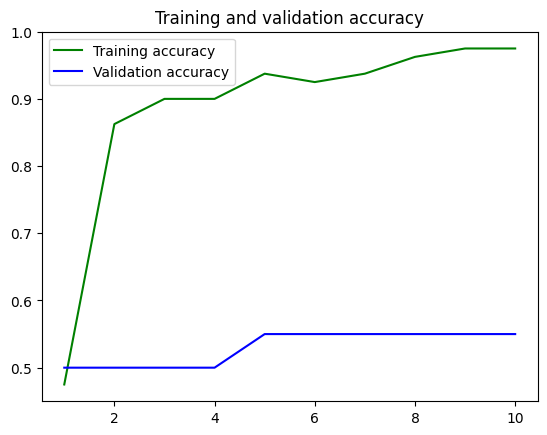

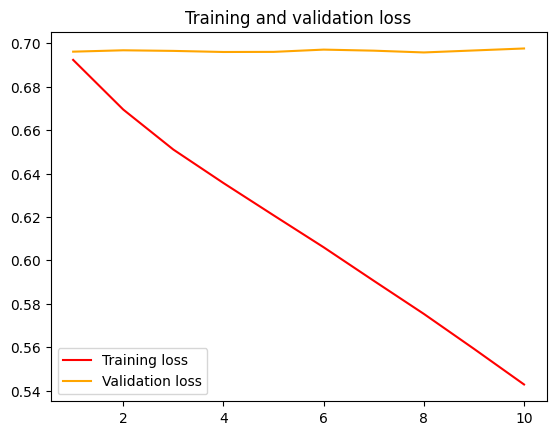

In [12]:
accuracy = history_2.history['acc']
val_accuracy = history_2.history['val_acc']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'green', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 2s 2ms/step - loss: 0.6966 - acc: 0.5042
Test loss: 0.6966116428375244
Test accuracy: 0.5041999816894531


##5. Bi-directional layers used

**Download the IMDB data as raw text - **

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [16]:
import os

In [17]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  6887k      0  0:00:11  0:00:11 --:--:-- 14.7M
^C


In [18]:
imdb_dir = '/content/drive/MyDrive'

In [19]:
train_dir = os.path.join(imdb_dir, 'train')

In [20]:
labels = []
texts = []

In [26]:
for label_type in ['/content/drive/MyDrive/aclImdb/train/neg', '/content/drive/MyDrive/aclImdb/train/pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

## Tokenizing the data 

3.   On 10K samples 
4.   Considering only top 10K samples



In [27]:
maxlen = 150 
training_samples = 100 
validation_samples = 10000  
max_words = 10000  

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# But first, shuffle the data because we started with data
# where the samples are arranged (all negative first, then all positive).

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88579 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


*Glove word embeddings*  

**Pre-Processing the embeddings**

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
glove_dir = '/content/drive/MyDrive/glove.6B'
import re, os
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [30]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
           #consider the no text as Zero
            embedding_matrix[i] = embedding_vector

Building the model

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


**Loading the GloVe embeddings in the model**

In [32]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [33]:
print("Training data shape:", y_train.shape)

Training data shape: (100,)


Train and evaluate

In [34]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history_3 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.3a')

Epoch 1/10
4/4 [==============================] - 5s 557ms/step - loss: 0.4887 - acc: 0.8600 - val_loss: 0.2039 - val_acc: 1.0000
Epoch 2/10
4/4 [==============================] - 3s 862ms/step - loss: 0.1670 - acc: 1.0000 - val_loss: 0.1133 - val_acc: 1.0000
Epoch 3/10
4/4 [==============================] - 2s 527ms/step - loss: 0.0975 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 1.0000
Epoch 4/10
4/4 [==============================] - 1s 362ms/step - loss: 0.0657 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 1.0000
Epoch 5/10
4/4 [==============================] - 1s 437ms/step - loss: 0.0469 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 1.0000
Epoch 6/10
4/4 [==============================] - 1s 368ms/step - loss: 0.0348 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 1.0000
Epoch 7/10
4/4 [==============================] - 1s 435ms/step - loss: 0.0273 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 1.0000
Epoch 8/10
4/4 [==============================] - 1s 436ms/step - loss: 0.0219 - acc: 1.00

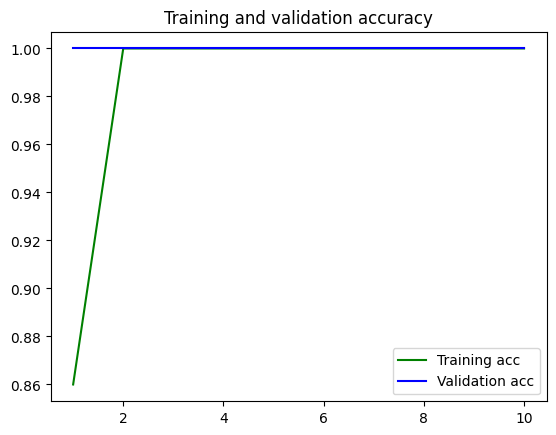

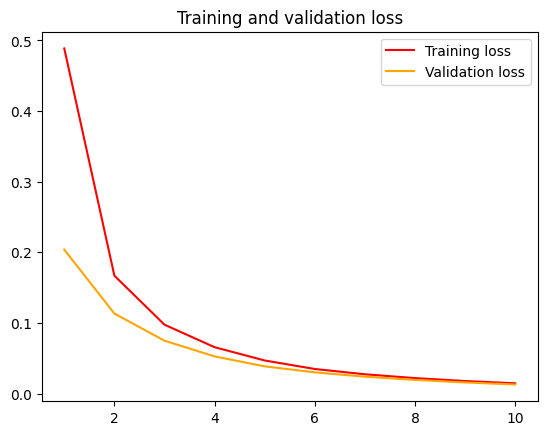

In [35]:
import matplotlib.pyplot as plt

acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
test_dir = os.path.join(imdb_dir, '/content/drive/MyDrive/aclImdb/test')

labels = []
texts = []

for label_type in ['/content/drive/MyDrive/aclImdb/train/neg', '/content/drive/MyDrive/aclImdb/train/pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [39]:
model.load_weights('pre_trained_glove_model.3a')
model.evaluate(x_test, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.0128 - acc: 1.0000


[0.012845621444284916, 1.0]

## Evaluating better performance through various training sample sizes.

* (i) Training embedded with 10K

In [40]:
max_features=10000
maxlen=150
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

texts = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((x_train, x_test), axis=0)

x_train = x_train[:1000]
y_train = y_train[:1000]

In [41]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history_4 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 8)            80000     
                                                                 
 flatten_2 (Flatten)         (None, 1200)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 5s 171ms/step - loss: 0.6939 - acc: 0.4925 - val_loss: 0.6902 - val_acc: 0.5650
Epoch 2/10
25/25 [==============================] - 2s 90ms/step - loss: 0.6768 - acc: 0.7650 - val_loss: 0.6885 - val_acc: 0.5800
Epoch 3/10
25/25 [==============================] -

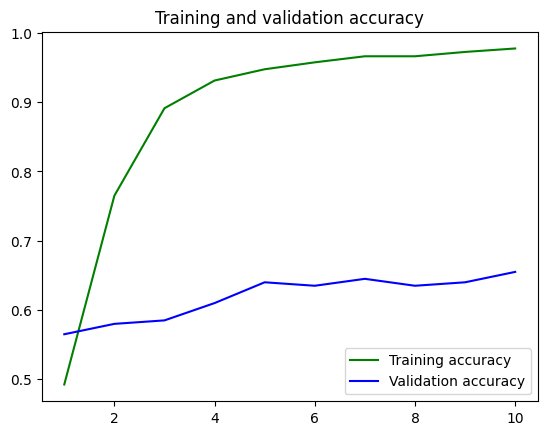

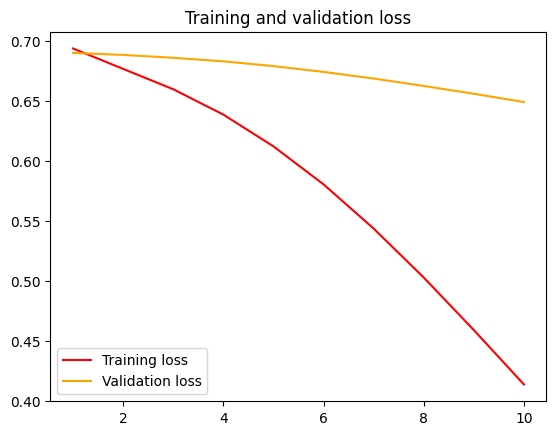

In [42]:
accuracy = history_4.history['acc']
val_accuracy = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'green', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 3s 3ms/step - loss: 0.6690 - acc: 0.5962
Test loss: 0.6689590811729431
Test accuracy: 0.5961999893188477


* (ii) Taining sample - 20K with
embedding layer and Conv1D

In [44]:
max_features=10000
maxlen=150
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

texts = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((x_train, x_test), axis=0)

x_train = x_train[:20000]
y_train = y_train[:20000]

In [45]:
model = Sequential()
model.add(Embedding(10000, 10, input_length=maxlen))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history_5 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 10)           100000    
                                                                 
 conv1d (Conv1D)             (None, 148, 512)          15872     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 256)          

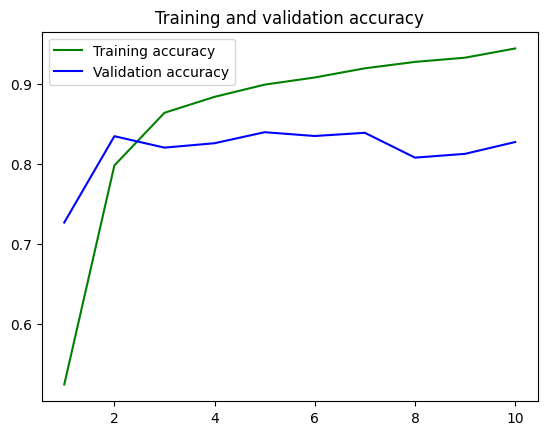

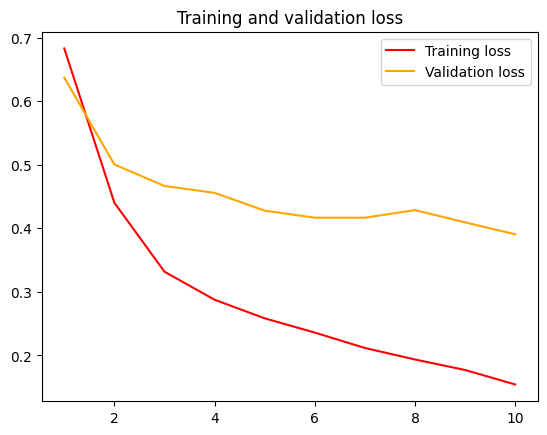

In [46]:
accuracy = history_5.history['acc']
val_accuracy = history_5.history['val_acc']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'green', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 3s 4ms/step - loss: 0.4182 - acc: 0.8072
Test loss: 0.4182033836841583
Test accuracy: 0.8071600198745728


Previously, training sample accuracy was still poor, but when we employed Con1D coupled with a larger training sample size, accuracy rose to 80%.

* (iii) Training sample- 30K with embedding layers and Conv1D

In [48]:
max_features=10000
maxlen=150
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

texts = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((x_train, x_test), axis=0)

x_train = x_train[:30000]
y_train = y_train[:30000]

In [49]:
model = Sequential()
model.add(Embedding(10000, 12, input_length=maxlen))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history_6 = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 12)           120000    
                                                                 
 conv1d_3 (Conv1D)           (None, 148, 512)          18944     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 49, 512)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 47, 256)           393472    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 15, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 13, 256)          

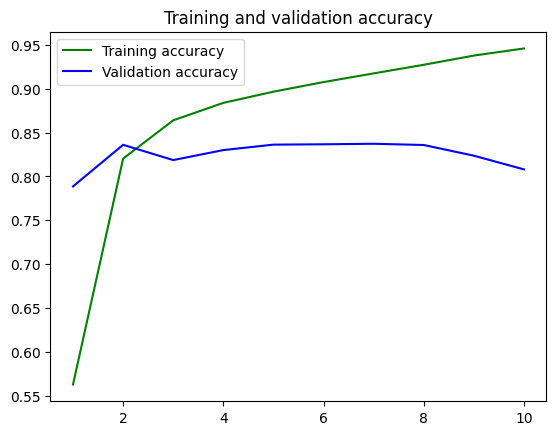

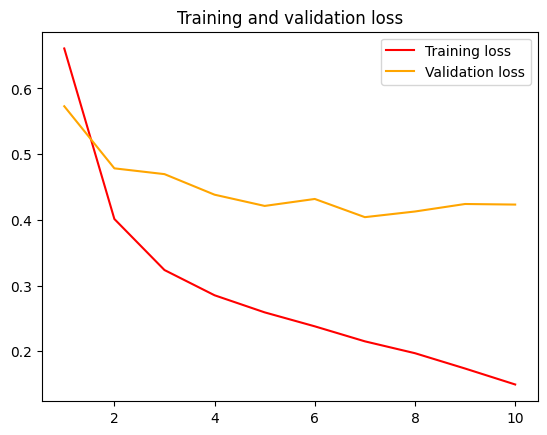

In [50]:
accuracy = history_6.history['acc']
val_accuracy = history_6.history['val_acc']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'green', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'blue', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [51]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

782/782 [==============================] - 3s 4ms/step - loss: 0.4373 - acc: 0.8005
Test loss: 0.43726301193237305
Test accuracy: 0.8005200028419495


**Using pretrained word embeddings**

In [81]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load pretrained word embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/aclImdb/imdbEr.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Set the maximum number of words to use and the embedding dimension
max_words = 10000
embedding_dim = 100

# Tokenize the text and create sequences of integer word indices
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad the sequences to have a consistent length
if len(sequences) > 0:
    max_sequence_length = max(len(s) for s in sequences)
else:
    max_sequence_length = 0

data = pad_sequences(sequences, maxlen=max_sequence_length)

# Create the embedding matrix
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the RNN model
model = Sequential()
model.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sequence_length,
                    trainable=False))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'], run_eagerly=True)
model.summary()

# Train the model
tf.config.run_functions_eagerly(True)  # enable eager execution


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 100)         100       
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 32)                4256      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,389
Trainable params: 4,289
Non-trainable params: 100
_________________________________________________________________


In [84]:
maxlen = 150  
training_samples = 15000
validation_samples = 10000 
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 0 unique tokens.
Shape of data tensor: (0, 150)
Shape of label tensor: (0,)


In [85]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 150, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [88]:
embedding_matrix = np.zeros((max_words, embedding_dim))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [89]:
print("Training data shape:", y_train.shape)

Training data shape: (0,)


In [107]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'],
              run_eagerly=True)


*Now working on 30K for pre-trained sample*

In [114]:
maxlen = 150  
training_samples = 30000 
validation_samples = 10000  
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:30000]
y_train = labels[:30000]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 0 unique tokens.
Shape of data tensor: (0, 150)
Shape of label tensor: (0,)


In [115]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(128))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [116]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [117]:
print("Training data shape:", y_train.shape)

Training data shape: (0,)


In [120]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.save_weights('pre_trained_glove_model.8a')

In [122]:
model.load_weights('pre_trained_glove_model.8a')
model.evaluate(x_test, y_test)

782/782 [==============================] - 19s 24ms/step - loss: 0.6931 - acc: 0.5000


[0.6931474804878235, 0.5]